# Package Imports

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model 
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

# Extract Image Features

In [3]:
model = VGG16()
# leaving out the predeiction layer
model = Model(inputs = model.inputs, outputs=model.layers[-2].output) 
print(model.summary())

553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load image and make it numpy array
    img_path = directory + '/'+ img_name
    image = load_img(img_path, target_size=(224,224))
    image = img_to_array(image) 
    # reshape and preprocess for vgg16 
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    # store feature
    extracted_feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = extracted_feature
    

In [ ]:
# store features in file for reference
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [4]:
# load features from pickle dump
with open(os.path.join('/kaggle/input/featuresandmodel/features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load captions

In [5]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r')as f:
    next(f)
    captions_doc = f.read()
# captions_doc

In [6]:
captions = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in captions:
        captions[image_id] = []
    captions[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

## Clean Data

In [7]:
print(captions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


In [8]:
def clean(img_captions_map):
    for img_id, caption_list in img_captions_map.items():
        for i in range(len(caption_list)):
            # remove non-alphabetical characters
            cap = caption_list[i]
            cap = cap.lower().replace('\s+','').replace('[^A-Za-z]','')
            cap = " ".join([word for word in cap.split() if len(word)>1])
            # add start and end tags
            cap = 'startseq ' + cap + ' endseq'
            caption_list[i] = cap
clean(captions)

In [9]:
print(captions['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


In [11]:
all_captions = []
for key in captions:
    for cap in captions[key]:
        all_captions.append(cap)
print(len(all_captions))
all_captions[:10]

40455


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1
max_length = max(len(caption.split()) for caption in all_captions) # for padding purposes
print(vocab_size)
print(max_length)

8485
35


# Train and Test Data

In [13]:
image_ids = list(captions.keys())
split = int(len(image_ids) * 0.90)
train,test = image_ids[:split], image_ids[split:]

## Batched Input

In [14]:
def data_generator(data_keys, caption_map, features_map, tokenizer, max_length, voacb_size, batch_size):
    X1, X2, Y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            caption_list = caption_map[key]
            for cap in caption_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1,len(seq)):
                    # input and output seq pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output seq
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features_map[key][0])
                    X2.append(in_seq)
                    Y.append(out_seq)
            if n == batch_size:
                X1, X2, Y = np.array(X1), np.array(X2), np.array(Y)
                yield [X1, X2], Y
                # reset variables to prevent memory overload
                X1, X2, Y = list(), list(), list()
                n = 0

## Model Creation

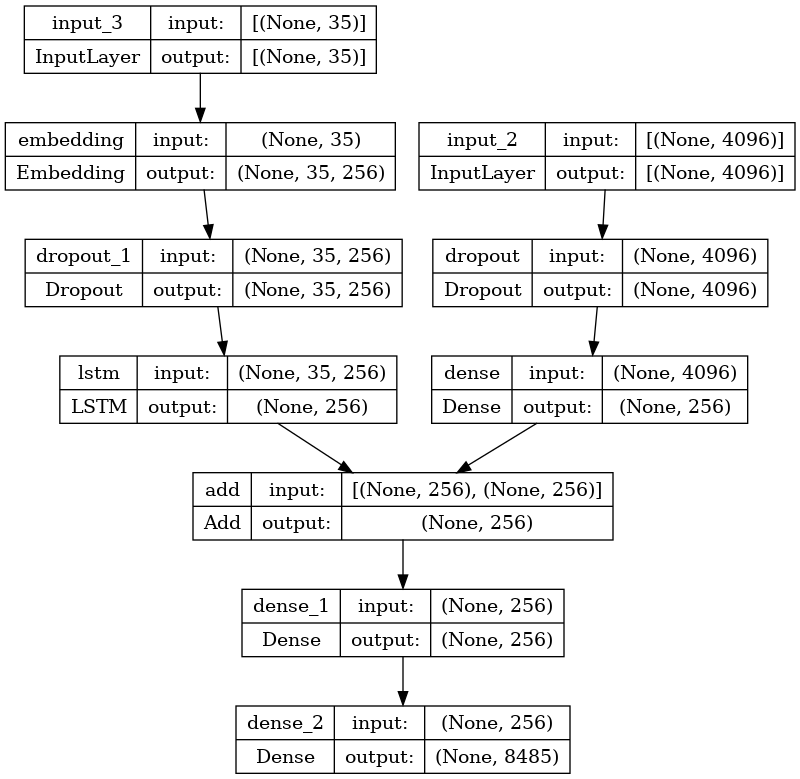

In [15]:
# encoder model
#image features
input_images = Input(shape=(4096,)) # the shape from vgg16
fe1 = Dropout(0.4)(input_images)
fe2 = Dense(256, activation='relu')(fe1)
# text features
input_captions = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(input_captions)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
dec1 = add([fe2,se3])
dec2 = Dense(256, activation='relu')(dec1)
outputs = Dense(vocab_size, activation='softmax')(dec2)

# compile them
model = Model(inputs=[input_images, input_captions], outputs = outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, show_shapes=True)

## Train and save model

In [16]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, captions, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 66s 291ms/step - loss: 2.6215


In [17]:
model.save(WORKING_DIR + '/mymodel.keras') 

# Generate Captions for an Image

In [18]:
def idx_to_word(idx, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == idx:
            return word
    return None

In [32]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq '
    for i in range(max_length):
        # encode and pad sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], max_length)
        # make prediction
        yhat = model.predict([image, seq], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test[:len(test)//2]) :
    caption_list = captions[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [cap.split() for cap in caption_list]
    actual.append(actual_captions)
    predicted.append(y_pred.split())
    
# BLEU score
print("BLEU-1: %f" %corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

  0%|          | 0/405 [00:00<?, ?it/s]

BLEU-1: 0.553990
BLEU-2: 0.331025


# Visualize Results

In [35]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
#     image_name = '1000268201_693b08cb0e.jpg'
    img_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, 'Images', image_name)
    image = Image.open(img_path)
    caption_list = captions[img_id]
    print("-------------Actual-----------")
    for cap in caption_list:
        print(cap)

    y_pred = predict_caption(model, features[img_id],tokenizer, max_length)
    print("------------Predicted---------")
    print(y_pred)
    plt.imshow(image)

-------------Actual-----------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
------------Predicted---------
startseq  two people eat on the stairs endseq


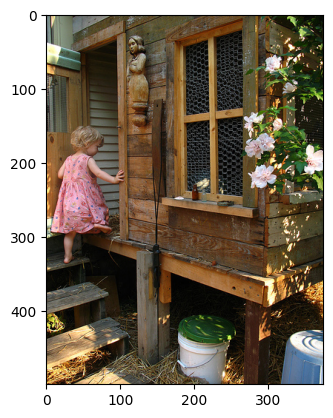

In [37]:
generate_caption('1000268201_693b08cb0e.jpg')

-------------Actual-----------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
------------Predicted---------
startseq  two dogs are playing with each other on the street endseq


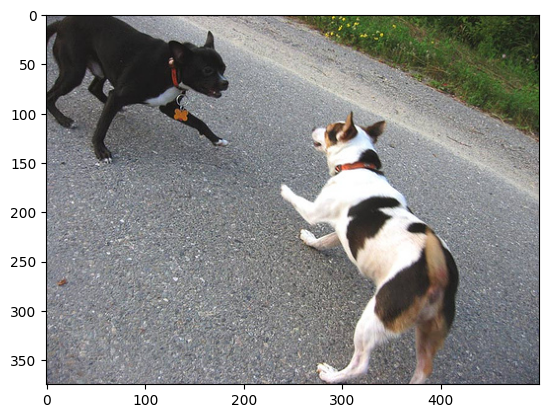

In [38]:
generate_caption('1001773457_577c3a7d70.jpg')